In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
max_date = session.query(func.max(Measurement.date)).scalar()
max_date

'2017-08-23'

In [10]:
# Design a query to retrieve the last 365 days of precipitation data and plot the results.
# Starting from the most recent data point in the database. 
endate = dt.datetime.strptime(max_date, '%Y-%m-%d').date()

# Calculate the date one year from the last date in data set.
startdate = endate - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp
#                        , Measurement.id, Measurement.station, Measurement.tobs
#                        , station.id , station.station, station.name, station.latitude, station.longitude, station.elevation
                       ).filter(Measurement.date >= startdate, Measurement.date <= endate).all()

# Save the query results as a Pandas DataFrame and sort DataFrame by date
df = pd.DataFrame(results).sort_values('date')

# Rename columns
df = df.rename(columns={'date':'Date','prcp':'Precipitation'})

# Set the index to the date column
df = df.set_index('Date')

# Drop NA
df = df.dropna()

df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70


[Text(0, 0, '2016-08-23'),
 Text(0, 0, '2016-08-23'),
 Text(0, 0, '2016-08-23'),
 Text(0, 0, '2016-08-23'),
 Text(0, 0, '2016-08-23'),
 Text(0, 0, '2016-08-23'),
 Text(0, 0, '2016-08-24'),
 Text(0, 0, '2016-08-24'),
 Text(0, 0, '2016-08-24'),
 Text(0, 0, '2016-08-24'),
 Text(0, 0, '2016-08-24')]

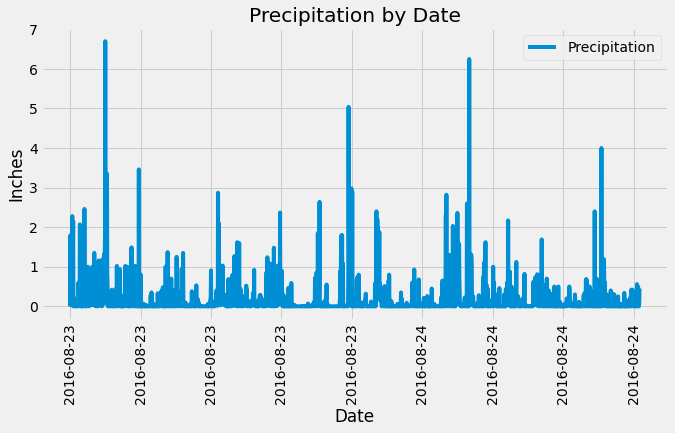

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
fig1 = df.plot(figsize=(10,5), title='Precipitation by Date')
fig1.set_xlabel('Date')
fig1.set_ylabel('Inches')
fig1.set_xticklabels(df.index,rotation=90)

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset


In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [16]:
# Close Session
session.close()